In [1]:
import scipy.io
import scipy.signal
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline
%config InlineBackend.figure_formats = set(['retina'])

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
data = scipy.io.loadmat("Accelerometer_data.mat")
print(data.keys())

x_train = np.hstack((data['train']['ax'][0,0], 
                     data['train']['ay'][0,0], 
                     data['train']['az'][0,0]))
y_train = data['train']['Y'][0,0].reshape(-1)

x_test = np.hstack((data['test']['ax'][0,0], 
                    data['test']['ay'][0,0], 
                    data['test']['az'][0,0]))
y_test = data['test']['Y'][0,0].reshape(-1)

actnames = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying']

dict_keys(['__header__', '__version__', '__globals__', 'actnames', 'fs', 'test', 'train'])


# Signal Pre-processing

### Apply Discrete Fourier Transform (DFT)

In [3]:
def buildX(set):
    ax_dft = np.fft.fft(data[set]['ax'][0,0], axis = 1)
    ay_dft = np.fft.fft(data[set]['ay'][0,0], axis = 1)
    az_dft = np.fft.fft(data[set]['az'][0,0], axis = 1)
    return np.absolute(np.hstack((ax_dft, ay_dft, az_dft)))

def buildAngleX(set):
    ax_dft = np.fft.fft(data[set]['ax'][0,0], axis = 1)
    ay_dft = np.fft.fft(data[set]['ay'][0,0], axis = 1)
    az_dft = np.fft.fft(data[set]['az'][0,0], axis = 1)
    return np.angle(np.hstack((ax_dft, ay_dft, az_dft)))

x_train_dft = buildX('train')
x_test_dft = buildX('test')

### Apply High-pass Filter on az

Gravity has a significant component along z axis, we will use a high pass filter to remove this.

In [4]:
b,a = scipy.signal.cheby2(N = 4, rs = 60, Wn = 0.4, btype = "highpass", output = "ba", fs = 50)

x_train = np.hstack((data['train']['ax'][0,0], 
                     data['train']['ay'][0,0], 
                     data['train']['az'][0,0]))
y_train = data['train']['Y'][0,0].reshape(-1)

x_test = np.hstack((data['test']['ax'][0,0], 
                    data['test']['ay'][0,0], 
                    data['test']['az'][0,0]))
y_test = data['test']['Y'][0,0].reshape(-1)

train_az_filted = scipy.signal.lfilter(b,a,data['train']['az'][0,0])
test_az_filted = scipy.signal.lfilter(b,a,data['test']['az'][0,0])

x_train_filted = np.hstack((data['train']['ax'][0,0], 
                     data['train']['ay'][0,0], 
                     train_az_filted))

x_test_filted = np.hstack((data['test']['ax'][0,0], 
                    data['test']['ay'][0,0], 
                    test_az_filted))

### Apply Discrete Fourier Transform (DFT) and High-pass Filter on az

In [5]:
def buildX(set, filted = False):
    ax_dft = np.fft.fft(data[set]['ax'][0,0], axis = 1)
    ay_dft = np.fft.fft(data[set]['ay'][0,0], axis = 1)
    if filted:
        az_filted = scipy.signal.lfilter(b,a,data[set]['az'][0,0])
        az_dft = np.fft.fft(az_filted, axis = 1)
    else:
        az_dft = np.fft.fft(data[set]['az'][0,0], axis = 1)
    return np.absolute(np.hstack((ax_dft, ay_dft, az_dft)))

x_train_filted_dft = buildX('train', filted = True)
x_test_filted_dft = buildX('test', filted = True)

### Discrete Cosine Transform

In [6]:
from numpy import empty,arange,exp,real,imag,pi
from numpy.fft import rfft,irfft

def dct(y):
    N = len(y)
    y2 = empty(2*N,float)
    y2[:N] = y[:]
    y2[N:] = y[::-1]

    c = rfft(y2)
    phi = exp(-1j*pi*arange(N)/(2*N))
    return real(phi*c[:N])

def dct_trans_dataset(y):
    y_dct = np.zeros(y.shape)
    for i in range(y.shape[0]):
        y_dct[i,:] = dct(y[i,:])
    return y_dct

x_train_dct = dct_trans_dataset(x_train)
x_test_dct = dct_trans_dataset(x_test)

### Wavelet transform

In [9]:
import pywt

def wt_trans_dataset(y):
    y_dct = np.zeros((y.shape[0], 128*32*3))
    for i in range(y.shape[0]):
        y_wt_x, _ = pywt.cwt(y[i,:128], np.arange(1,33), 'morl')
        y_wt_y, _ = pywt.cwt(y[i,128:256], np.arange(1,33), 'morl')
        y_wt_z, _ = pywt.cwt(y[i,256:], np.arange(1,33), 'morl')
        y_dct[i,:] = np.hstack((y_wt_x.reshape(-1), y_wt_y.reshape(-1), y_wt_z.reshape(-1)))
    return y_dct

x_train_wt = wt_trans_dataset(x_train)
x_test_wt = wt_trans_dataset(x_test)

### Fisher's LDA

In [22]:
from scipy.linalg import eig

def fisher_LDA(x_train, y_train, n_dim = 20):
    SW = 0
    SB = 0
    mu = np.mean(x_train, axis = 0)

    for i in range(1,7):
        x_slice = x_train[y_train == i,:]
        mu_i = np.mean(x_slice, axis = 0)
        x_slice -= mu_i
        SW += x_slice.T @ x_slice
        SB += x_slice.shape[0] * np.outer(mu_i-mu, mu_i-mu)

    eigenval, eigenvec = eig(SB, SW)
    idx = eigenval.argsort()[::-1]
    A = np.real(eigenvec[:, idx])[:,:n_dim]
    return A

A1 = fisher_LDA(x_train, y_train)
x_train_lda = x_train @ A1
x_test_lda = x_test @ A1

A2 = fisher_LDA(x_train_dft, y_train)
x_train_dft_lda = x_train_dft @ A2
x_test_dft_lda = x_test_dft @ A2

A3 = fisher_LDA(x_train_dct, y_train)
x_train_dct_lda = x_train_dct @ A3
x_test_dct_lda = x_test_dct @ A3


In [ ]:
# A4 = fisher_LDA(x_train_wt, y_train, 384)
# x_train_wt_lda = x_train_wt @ A4
# x_test_wt_lda = x_test_wt @ A4

### PCA

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

pca.fit(x_train_dft)
x_train_dft_pca = pca.transform(x_train_dft)
x_test_dft_pca = pca.transform(x_test_dft)

pca.fit(x_train_wt)
x_train_wt_pca = pca.transform(x_train_wt)
x_test_wt_pca = pca.transform(x_test_wt)

# K-nearest-neighbor

### Try k-NN in time domain

In [9]:
clf1 = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf1.fit(x_train, y_train)
y_pred_1 = clf1.predict(x_test)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_1)))

clf3 = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf3.fit(x_train, y_train)
y_pred_3 = clf3.predict(x_test)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_3)))

clf5 = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf5.fit(x_train, y_train)
y_pred_5 = clf5.predict(x_test)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_5)))

Accuracy for k=1: 0.7233009708737864
Accuracy for k=3: 0.6456310679611651
Accuracy for k=5: 0.6116504854368932


Confusion matrix:


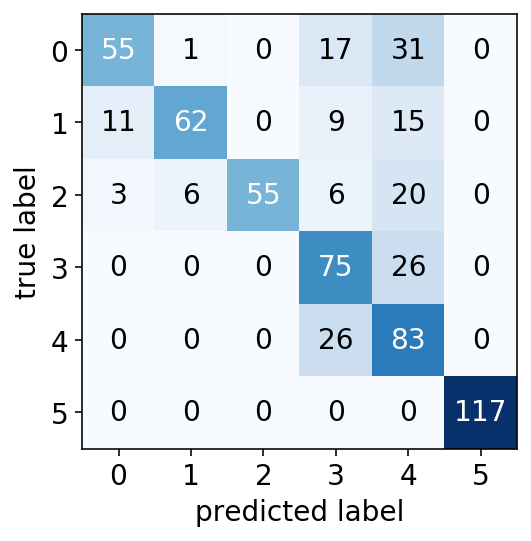

In [10]:
matplotlib.rcParams['figure.figsize'] = (4, 4)
matplotlib.rcParams.update({'font.size': 14})

confMatrix1 = confusion_matrix(y_test, y_pred_1)
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(confMatrix1)
plt.show()


### Try k-NN in frequency domain

In [11]:
clf_dft = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_dft.fit(x_train_dft, y_train)
y_pred_dft = clf_dft.predict(x_test_dft)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_dft)))

clf_dft = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf_dft.fit(x_train_dft, y_train)
y_pred_dft = clf_dft.predict(x_test_dft)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_dft)))

clf_dft = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf_dft.fit(x_train_dft, y_train)
y_pred_dft = clf_dft.predict(x_test_dft)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_dft)))

Accuracy for k=1: 0.8284789644012945
Accuracy for k=3: 0.8300970873786407
Accuracy for k=5: 0.8300970873786407


Confusion matrix:


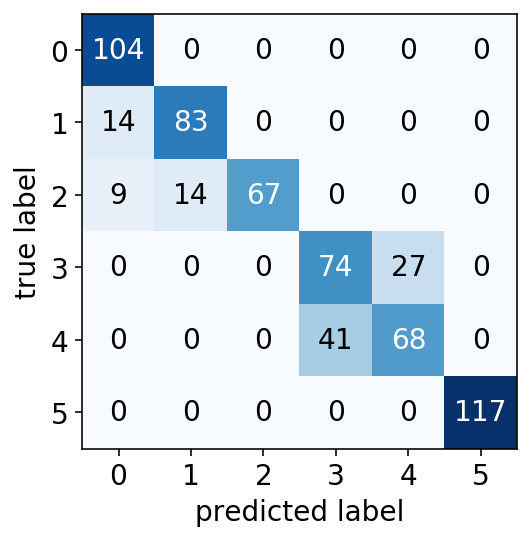

In [12]:
confMatrix2 = confusion_matrix(y_test, y_pred_dft)
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(confMatrix2)
plt.show()

### Try k-NN on filted data in time domain

In [13]:
clf1_filted = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf1_filted.fit(x_train_filted, y_train)
y_pred_1_filted = clf1_filted.predict(x_test_filted)
print('Accuracy for k=1, trained with filtered data: ' + str(accuracy_score(y_test, y_pred_1_filted)))

clf3_filted = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf3_filted.fit(x_train_filted, y_train)
y_pred_3_filted = clf3_filted.predict(x_test_filted)
print('Accuracy for k=3, trained with filtered data: ' + str(accuracy_score(y_test, y_pred_3_filted)))

clf5_filted = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf5_filted.fit(x_train_filted, y_train)
y_pred_5_filted = clf5_filted.predict(x_test_filted)
print('Accuracy for k=5, trained with filtered data: ' + str(accuracy_score(y_test, y_pred_5_filted)))

Accuracy for k=1, trained with filtered data: 0.7815533980582524
Accuracy for k=3, trained with filtered data: 0.7103559870550162
Accuracy for k=5, trained with filtered data: 0.6812297734627831


Confusion matrix:


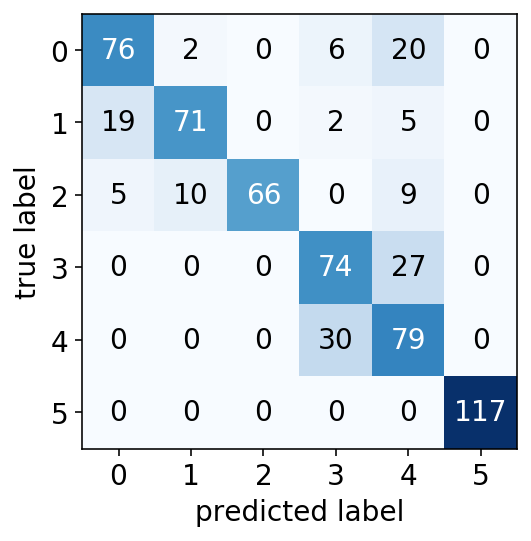

In [14]:
matplotlib.rcParams['figure.figsize'] = (4, 4)
confMatrix4 = confusion_matrix(y_test, y_pred_1_filted)
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(confMatrix4)
plt.show()

### Try k-NN on filted data in frequency domain

In [15]:
clf_dft = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_dft.fit(x_train_filted_dft, y_train)
y_pred_filted_dft = clf_dft.predict(x_test_filted_dft)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_filted_dft)))

clf_dft = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf_dft.fit(x_train_filted_dft, y_train)
y_pred_filted_dft = clf_dft.predict(x_test_filted_dft)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_filted_dft)))

clf_dft = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf_dft.fit(x_train_filted_dft, y_train)
y_pred_filted_dft = clf_dft.predict(x_test_filted_dft)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_filted_dft)))

Accuracy for k=1: 0.8122977346278317
Accuracy for k=3: 0.8074433656957929
Accuracy for k=5: 0.8025889967637541


Confusion matrix:


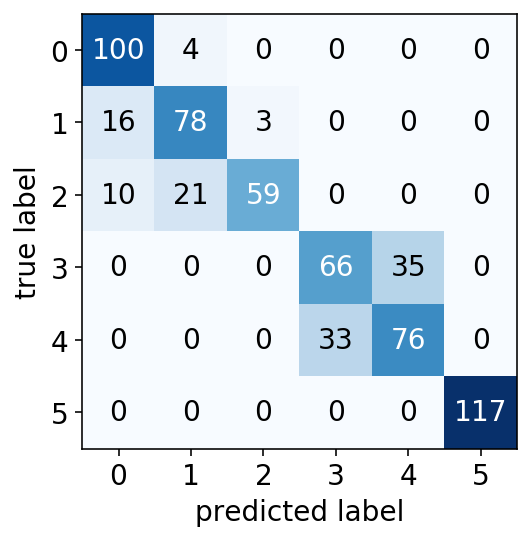

In [16]:
matplotlib.rcParams['figure.figsize'] = (4, 4)
confMatrix5 = confusion_matrix(y_test, y_pred_filted_dft)
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(confMatrix5)
plt.show()

Accuracy droped when apply DFT to filted data!

### Try k-NN with DCT

In [22]:
clf_dct = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_dct.fit(x_train_dct, y_train)
y_pred_dct = clf_dct.predict(x_test_dct)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_dct)))

clf_dct = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf_dct.fit(x_train_dct, y_train)
y_pred_dct = clf_dct.predict(x_test_dct)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_dct)))

clf_dct = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf_dct.fit(x_train_dct, y_train)
y_pred_dct = clf_dct.predict(x_test_dct)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_dct)))

Accuracy for k=1: 0.7152103559870551
Accuracy for k=3: 0.63915857605178
Accuracy for k=5: 0.5922330097087378


Confusion matrix:


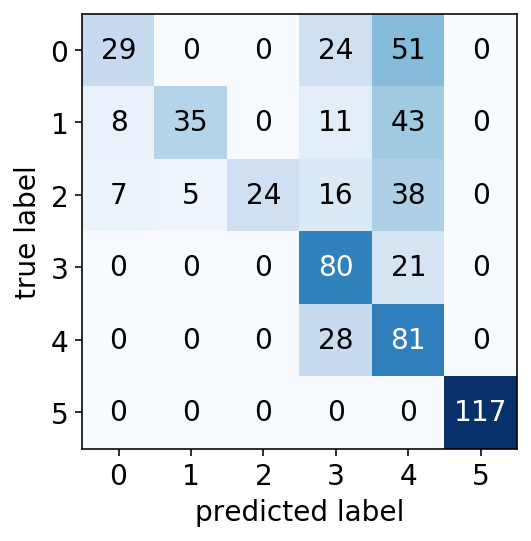

In [19]:
matplotlib.rcParams['figure.figsize'] = (4, 4)
confMatrix5 = confusion_matrix(y_test, y_pred_dct)
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(confMatrix5)
plt.show()

### Try k-NN with WT

In [14]:
clf_wt = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_wt.fit(x_train_wt, y_train)
y_pred_wt = clf_wt.predict(x_test_wt)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_wt)))

clf_wt = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf_wt.fit(x_train_wt, y_train)
y_pred_wt = clf_wt.predict(x_test_wt)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_wt)))

clf_wt = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf_wt.fit(x_train_wt, y_train)
y_pred_wt = clf_wt.predict(x_test_wt)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_wt)))

Accuracy for k=1: 0.8300970873786407
Accuracy for k=3: 0.8220064724919094
Accuracy for k=5: 0.8025889967637541


Confusion matrix:


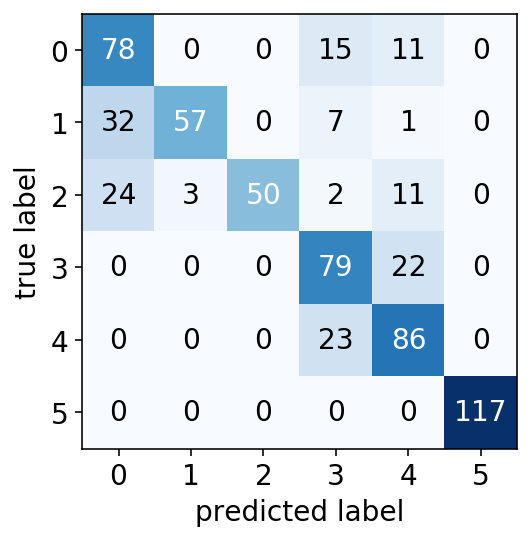

In [21]:
matplotlib.rcParams['figure.figsize'] = (4, 4)
confMatrix5 = confusion_matrix(y_test, y_pred_wt)
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(confMatrix5)
plt.show()

### Try k-NN with LDA

In [23]:
clf_knn = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_knn.fit(x_train_lda, y_train)
y_pred_knn = clf_knn.predict(x_test_lda)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_knn)))

clf_knn = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf_knn.fit(x_train_lda, y_train)
y_pred_knn = clf_knn.predict(x_test_lda)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_knn)))

clf_knn = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf_knn.fit(x_train_lda, y_train)
y_pred_knn = clf_knn.predict(x_test_lda)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_knn)))

Accuracy for k=1: 0.6116504854368932
Accuracy for k=3: 0.6375404530744336
Accuracy for k=5: 0.6359223300970874


In [24]:
clf_knn = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_knn.fit(x_train_dft_lda, y_train)
y_pred_knn = clf_knn.predict(x_test_dft_lda)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_knn)))

clf_knn = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf_knn.fit(x_train_dft_lda, y_train)
y_pred_knn = clf_knn.predict(x_test_dft_lda)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_knn)))

clf_knn = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf_knn.fit(x_train_dft_lda, y_train)
y_pred_knn = clf_knn.predict(x_test_dft_lda)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_knn)))


Accuracy for k=1: 0.7524271844660194
Accuracy for k=3: 0.7864077669902912
Accuracy for k=5: 0.7961165048543689


### Try k-NN with PCA

In [11]:
clf_knn = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_knn.fit(x_train_pca, y_train)
y_pred_knn = clf_knn.predict(x_test_pca)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_knn)))

clf_knn = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf_knn.fit(x_train_pca, y_train)
y_pred_knn = clf_knn.predict(x_test_pca)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_knn)))

clf_knn = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf_knn.fit(x_train_pca, y_train)
y_pred_knn = clf_knn.predict(x_test_pca)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_knn)))

Accuracy for k=1: 0.7702265372168284
Accuracy for k=3: 0.7297734627831716
Accuracy for k=5: 0.686084142394822


In [12]:
clf_knn = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_knn.fit(x_train_dft_pca, y_train)
y_pred_knn = clf_knn.predict(x_test_dft_pca)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_knn)))

clf_knn = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf_knn.fit(x_train_dft_pca, y_train)
y_pred_knn = clf_knn.predict(x_test_dft_pca)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_knn)))

clf_knn = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf_knn.fit(x_train_dft_pca, y_train)
y_pred_knn = clf_knn.predict(x_test_dft_pca)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_knn)))

Accuracy for k=1: 0.8268608414239482
Accuracy for k=3: 0.8203883495145631
Accuracy for k=5: 0.8203883495145631


In [13]:
clf_knn = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_knn.fit(x_train_wt_pca, y_train)
y_pred_knn = clf_knn.predict(x_test_wt_pca)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_knn)))

clf_knn = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf_knn.fit(x_train_wt_pca, y_train)
y_pred_knn = clf_knn.predict(x_test_wt_pca)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_knn)))

clf_knn = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf_knn.fit(x_train_wt_pca, y_train)
y_pred_knn = clf_knn.predict(x_test_wt_pca)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_knn)))

Accuracy for k=1: 0.8333333333333334
Accuracy for k=3: 0.8171521035598706
Accuracy for k=5: 0.8042071197411004


# Try SVM

In [23]:
from sklearn.svm import SVC
clf_SVM = SVC(C=1, gamma='scale', kernel='rbf')
clf_SVM.fit(x_train, y_train)
y_pred_SVM = clf_SVM.predict(x_test)
print('Accuracy for SVM: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_dft, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dft)
print('Accuracy for SVM_dft: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_filted, y_train)
y_pred_SVM = clf_SVM.predict(x_test_filted)
print('Accuracy for SVM_filted: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_filted_dft, y_train)
y_pred_SVM = clf_SVM.predict(x_test_filted_dft)
print('Accuracy for SVM_filted_dft: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_dct, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dct)
print('Accuracy for SVM_dct: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_wt, y_train)
y_pred_SVM = clf_SVM.predict(x_test_wt)
print('Accuracy for SVM_wt: ' + str(accuracy_score(y_test, y_pred_SVM)))

Accuracy for SVM: 0.6925566343042071
Accuracy for SVM_dft: 0.8171521035598706
Accuracy for SVM_filted: 0.7152103559870551
Accuracy for SVM_filted_dft: 0.7928802588996764
Accuracy for SVM_dct: 0.610032362459547
Accuracy for SVM_wt: 0.8284789644012945


In [26]:
from sklearn.svm import SVC
clf_SVM = SVC(C=5, gamma='scale', kernel='rbf')
clf_SVM.fit(x_train, y_train)
y_pred_SVM = clf_SVM.predict(x_test)
print('Accuracy for SVM: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_dft, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dft)
print('Accuracy for SVM_dft: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_filted, y_train)
y_pred_SVM = clf_SVM.predict(x_test_filted)
print('Accuracy for SVM_filted: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_filted_dft, y_train)
y_pred_SVM = clf_SVM.predict(x_test_filted_dft)
print('Accuracy for SVM_filted_dft: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_dct, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dct)
print('Accuracy for SVM_dct: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_wt, y_train)
y_pred_SVM = clf_SVM.predict(x_test_wt)
print('Accuracy for SVM_wt: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_lda, y_train)
y_pred_SVM = clf_SVM.predict(x_test_lda)
print('Accuracy for SVM_lda: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_dft_lda, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dft_lda)
print('Accuracy for SVM_dft_lda: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_pca, y_train)
y_pred_SVM = clf_SVM.predict(x_test_pca)
print('Accuracy for SVM_pca: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_dft_pca, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dft_pca)
print('Accuracy for SVM_dft_pca: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_wt_pca, y_train)
y_pred_SVM = clf_SVM.predict(x_test_wt_pca)
print('Accuracy for SVM_wt_pca: ' + str(accuracy_score(y_test, y_pred_SVM)))

Accuracy for SVM: 0.7702265372168284
Accuracy for SVM_dft: 0.8381877022653722
Accuracy for SVM_filted: 0.7799352750809061
Accuracy for SVM_filted_dft: 0.8333333333333334
Accuracy for SVM_dct: 0.7184466019417476
Accuracy for SVM_wt: 0.8948220064724919
Accuracy for SVM_lda: 0.6375404530744336
Accuracy for SVM_dft_lda: 0.7637540453074434
Accuracy for SVM_pca: 0.7961165048543689
Accuracy for SVM_dft_pca: 0.8624595469255664
Accuracy for SVM_wt_pca: 0.8851132686084142


In [25]:
from sklearn.svm import SVC
clf_SVM = SVC(C=25, gamma='scale', kernel='rbf')
clf_SVM.fit(x_train, y_train)
y_pred_SVM = clf_SVM.predict(x_test)
print('Accuracy for SVM: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_dft, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dft)
print('Accuracy for SVM_dft: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_filted, y_train)
y_pred_SVM = clf_SVM.predict(x_test_filted)
print('Accuracy for SVM_filted: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_filted_dft, y_train)
y_pred_SVM = clf_SVM.predict(x_test_filted_dft)
print('Accuracy for SVM_filted_dft: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_dct, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dct)
print('Accuracy for SVM_dct: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_wt, y_train)
y_pred_SVM = clf_SVM.predict(x_test_wt)
print('Accuracy for SVM_wt: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_lda, y_train)
y_pred_SVM = clf_SVM.predict(x_test_lda)
print('Accuracy for SVM_lda: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_dft_lda, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dft_lda)
print('Accuracy for SVM_dft_lda: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_pca, y_train)
y_pred_SVM = clf_SVM.predict(x_test_pca)
print('Accuracy for SVM_pca: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_dft_pca, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dft_pca)
print('Accuracy for SVM_dft_pca: ' + str(accuracy_score(y_test, y_pred_SVM)))

clf_SVM.fit(x_train_wt_pca, y_train)
y_pred_SVM = clf_SVM.predict(x_test_wt_pca)
print('Accuracy for SVM_wt_pca: ' + str(accuracy_score(y_test, y_pred_SVM)))

Accuracy for SVM: 0.8025889967637541
Accuracy for SVM_dft: 0.8592233009708737
Accuracy for SVM_filted: 0.8187702265372169
Accuracy for SVM_filted_dft: 0.8462783171521036
Accuracy for SVM_dct: 0.7896440129449838
Accuracy for SVM_wt: 0.8964401294498382
Accuracy for SVM_lda: 0.6375404530744336
Accuracy for SVM_dft_lda: 0.7702265372168284
Accuracy for SVM_pca: 0.8317152103559871
Accuracy for SVM_dft_pca: 0.872168284789644
Accuracy for SVM_wt_pca: 0.8851132686084142


# Try XGB
Use a very naive gradient boosting tree model with frequency domain inputs. The inputs now includes both the magnitudes and the angles of DFT of signals.

In [19]:
import xgboost as xgb

[0]	train-merror:0.0638	eval-merror:0.262136
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.009015	eval-merror:0.200647
[20]	train-merror:0	eval-merror:0.186084
[30]	train-merror:0	eval-merror:0.187702
Stopping. Best iteration:
[22]	train-merror:0	eval-merror:0.18123

Accuracy for XGB: 0.8187702265372169
Confusion matrix for XGB:


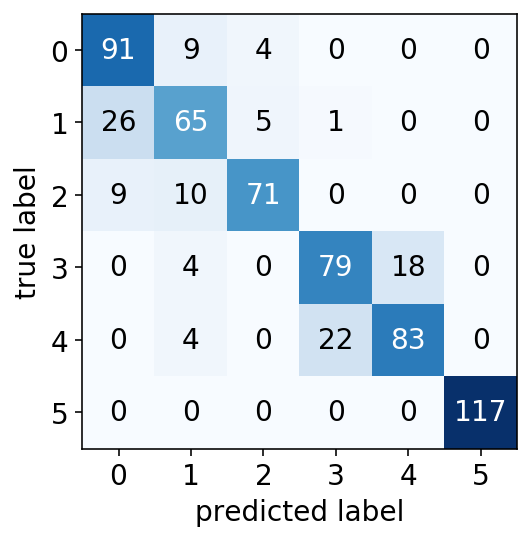

In [28]:
dtrain = xgb.DMatrix(x_train, label = y_train-1)
dtest = xgb.DMatrix(x_test, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))
confMatrix3 = confusion_matrix(y_test, y_pred_xgb)
print('Confusion matrix for XGB:')
fig, ax = plot_confusion_matrix(confMatrix3)
plt.show()

[0]	train-merror:0.033287	eval-merror:0.192557
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.002774	eval-merror:0.156958
[20]	train-merror:0	eval-merror:0.142395
[30]	train-merror:0	eval-merror:0.134304
[40]	train-merror:0	eval-merror:0.12945
[50]	train-merror:0	eval-merror:0.134304
Stopping. Best iteration:
[40]	train-merror:0	eval-merror:0.12945

Accuracy for XGB: 0.8656957928802589
Confusion matrix for XGB:


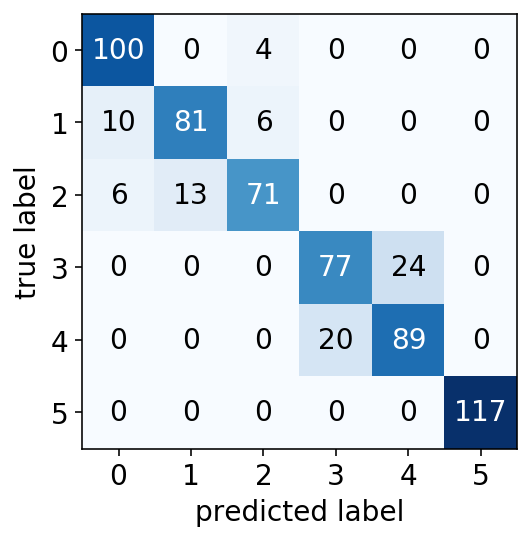

In [29]:
x_train_xgb = np.hstack((x_train_dft, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_dft, buildAngleX('test')))

dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]

num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
# Using the test set to early stop in order to avoid over-fitting

y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))
confMatrix3 = confusion_matrix(y_test, y_pred_xgb)
print('Confusion matrix for XGB:')
fig, ax = plot_confusion_matrix(confMatrix3)
plt.show()

In [30]:
x_train_xgb = np.hstack((x_train_filted, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_filted, buildAngleX('test')))

dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))

[0]	train-merror:0.058946	eval-merror:0.281553
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.003467	eval-merror:0.231392
[20]	train-merror:0	eval-merror:0.221683
[30]	train-merror:0	eval-merror:0.208738
[40]	train-merror:0	eval-merror:0.200647
[50]	train-merror:0	eval-merror:0.203883
Stopping. Best iteration:
[40]	train-merror:0	eval-merror:0.200647

Accuracy for XGB: 0.7961165048543689


In [31]:
x_train_xgb = np.hstack((x_train_filted_dft, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_filted_dft, buildAngleX('test')))

dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))

[0]	train-merror:0.02982	eval-merror:0.197411
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.000693	eval-merror:0.145631
[20]	train-merror:0	eval-merror:0.140777
[30]	train-merror:0	eval-merror:0.135922
Stopping. Best iteration:
[29]	train-merror:0	eval-merror:0.134304

Accuracy for XGB: 0.8640776699029126


In [32]:
x_train_xgb = np.hstack((x_train_dct, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_dct, buildAngleX('test')))

dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))

[0]	train-merror:0.050624	eval-merror:0.312298
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.00208	eval-merror:0.221683
[20]	train-merror:0	eval-merror:0.216828
[30]	train-merror:0	eval-merror:0.216828
Stopping. Best iteration:
[21]	train-merror:0	eval-merror:0.213592

Accuracy for XGB: 0.7847896440129449


In [33]:
x_train_xgb = np.hstack((x_train_wt, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_wt, buildAngleX('test')))

dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))

[0]	train-merror:0.034674	eval-merror:0.223301
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.000693	eval-merror:0.171521
[20]	train-merror:0	eval-merror:0.165049
[30]	train-merror:0	eval-merror:0.161812
Stopping. Best iteration:
[25]	train-merror:0	eval-merror:0.158576

Accuracy for XGB: 0.8349514563106796


In [27]:
x_train_xgb = np.hstack((x_train_lda, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_lda, buildAngleX('test')))

dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))

[0]	train-merror:0.057559	eval-merror:0.407767
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.007628	eval-merror:0.386731
Stopping. Best iteration:
[4]	train-merror:0.029126	eval-merror:0.380259

Accuracy for XGB: 0.6116504854368932


In [28]:
x_train_xgb = np.hstack((x_train_dft_lda, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_dft_lda, buildAngleX('test')))

dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))

[0]	train-merror:0.051318	eval-merror:0.192557
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.000693	eval-merror:0.18932
[20]	train-merror:0	eval-merror:0.179612
[30]	train-merror:0	eval-merror:0.177994
[40]	train-merror:0	eval-merror:0.179612
Stopping. Best iteration:
[31]	train-merror:0	eval-merror:0.176375

Accuracy for XGB: 0.8203883495145631


In [20]:
x_train_xgb = np.hstack((x_train_pca, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_pca, buildAngleX('test')))

dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))

[0]	train-merror:0.060333	eval-merror:0.273463
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.000693	eval-merror:0.213592
[20]	train-merror:0	eval-merror:0.203883
Stopping. Best iteration:
[12]	train-merror:0	eval-merror:0.199029

Accuracy for XGB: 0.7944983818770227


In [21]:
x_train_xgb = np.hstack((x_train_dft_pca, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_dft_pca, buildAngleX('test')))

dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))

[0]	train-merror:0.0319	eval-merror:0.158576
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.001387	eval-merror:0.116505
[20]	train-merror:0	eval-merror:0.11165
Stopping. Best iteration:
[19]	train-merror:0	eval-merror:0.110032

Accuracy for XGB: 0.8883495145631068


In [52]:
x_train_xgb = np.hstack((x_train_wt_pca, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_wt_pca, buildAngleX('test')))

dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))

[0]	train-merror:0.053398	eval-merror:0.281553
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0	eval-merror:0.190939
[20]	train-merror:0	eval-merror:0.179612
[30]	train-merror:0	eval-merror:0.182848
Stopping. Best iteration:
[20]	train-merror:0	eval-merror:0.179612

Accuracy for XGB: 0.8171521035598706
